In [1]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
from ..utils import drawPoints, epilinePlot, imshow, imshow2
from tqdm import tqdm_notebook
from collections import defaultdict

In [3]:
imgl_pts = np.load('../calibration/blob_loc_left.npy')
imgr_pts = np.load('../calibration/blob_loc_right.npy')

In [4]:
# Load points for F estimation
def correspondPtsForF(ptsL_end, ptsR_end, ptsL_out, ptsR_out, idx_out, num, end_only=False):
    pts_F_left = []
    pts_F_right = []

    ptsL_end_col = []
    ptsR_end_col = []
    for i in ptsL_end.keys():
        ptL = ptsL_end[i]
        ptR = ptsR_end[i]
        ptsL_end_col.append(ptL)
        ptsR_end_col.append(ptR)

    ptsL_out_col = []
    ptsR_out_col = []
    for i in idx_out:
        if i in ptsL_out:
            if i in ptsR_out:
                ptL = ptsL_out[i]
                ptR = ptsR_out[i]
                ptsL_out_col.append(ptL)
                ptsR_out_col.append(ptR)
    
    if end_only:
        sampleNum = num
        pts_F_left = ptsL_end_col[0:sampleNum]
        pts_F_right = ptsR_end_col[0:sampleNum]
    else:
        sampleNum = int(num/2)
        pts_F_left = ptsL_end_col[0:sampleNum] + ptsL_out_col[0:sampleNum] 
        pts_F_right = ptsR_end_col[0:sampleNum] + ptsR_out_col[0:sampleNum] 
        


    return np.array(pts_F_left), np.array(pts_F_right)

In [4]:
# Load template poitns
pts_F_left = []
pts_F_right = []
for ele in imgl_pts:
    pts_F_left.append(ele[0])
for ele in imgr_pts:
    pts_F_right.append(ele[0])


# Load image points 
pt_left = np.load('./data_F/ptsL200.npy').item()
pt_right = np.load('./data_F/ptsR200.npy').item()
for i in range(len(pt_left)):
    ptL = pt_left[i]
    ptR = pt_right[i]
    if len(ptL) == len(ptR):
        for elel, eler in zip(ptL, ptR):
            pts_F_left.append(elel)
            pts_F_right.append(eler)

pts_F_left = np.array(pts_F_left)
pts_F_right = np.array(pts_F_right)

F, mask = cv2.findFundamentalMat(pts_F_left, pts_F_right, cv2.FM_LMEDS)

In [6]:
ptsL_end = np.load('./data_F/ptsL800_end.npy').item()
ptsR_end = np.load('./data_F/ptsR800_end.npy').item()

ptsL_out = np.load('./data_F/ptsL800_out.npy').item()
ptsR_out = np.load('./data_F/ptsR800_out.npy').item()

idx_out = np.load('./data_F/eval_idx.npy')


pts_F_left, pts_F_right = correspondPtsForF(ptsL_end, ptsR_end, ptsL_out, ptsR_out, idx_out, num = 160)
# Estimate fundamental matrix
F, mask = cv2.findFundamentalMat(pts_F_left, pts_F_right, cv2.FM_LMEDS) #FM_RANSAC FM_LMEDS FM_8POINT 

In [13]:
# test on images
idx = 0
imgl = cv2.imread('../../data/CTR_Robot/Camera2/cam2_500.png')
imgr = cv2.imread('../../data/CTR_Robot/Camera1/cam1_500.png')
#imgl = cv2.imread('../segmentation/seg_result/seg' + str(index) + '_r.png')
#imgr = cv2.imread('../segmentation/seg_result/seg' + str(index) + '_l.png')

class ptCoord:
    def __init__(self):
        self.points = (0,0)

    def click_and_mark(self,event,x,y,flags,param):
        if event == cv2.EVENT_LBUTTONDOWN:
            self.points = (x,y)

pt = ptCoord()

while True:
    cv2.namedWindow('imgLeft')
    cv2.namedWindow('imgRight')
    cv2.setMouseCallback('imgLeft', pt.click_and_mark)
    cv2.imshow('imgLeft',imgr)
    cv2.imshow('imgRight', imgl)
    #print(pt.points)
    k = cv2.waitKey(20) & 0xFF
    if k == 27:
        break
    elif k == ord('a'):
        imgl_undist, imgr_undist = epilinePlot(np.array([pt.points]), imgr, imgl, F, 2)
cv2.destroyAllWindows()

In [14]:
cv2.imwrite('epilinePlotL.jpg', imgl)

True

In [23]:
## Use template points for evaluation
pts_eval_L = []
pts_eval_R = []
#for ele in imgl_pts:
#    pts_eval_L.append(ele[0])
#for ele in imgr_pts:
#    pts_eval_R.append(ele[0])

## Use end points for evaluation
for key in ptsL_out.keys():
    if key > 200:
        if key in ptsR_out:
            pts_eval_L.append(ptsL_out[key])
            pts_eval_R.append(ptsR_out[key])


def evaluate(pts_eval_L, pts_eval_R, F):    
    # Load points for evaluation

    pts_eval_L = np.array(pts_eval_L)
    pts_eval_R = np.array(pts_eval_R)

    # Left line ===> right points
    # Right line ===> left points
    linesL = cv2.computeCorrespondEpilines(pts_eval_L.reshape(-1, 1, 2), 1, F)
    linesR = cv2.computeCorrespondEpilines(pts_eval_R.reshape(-1, 1, 2), 2, F)

    linesL = linesL.reshape(-1, 3)
    linesR = linesR.reshape(-1, 3)

    pt_num = len(pts_eval_L)
    bias = np.ones((pt_num, 1))
    ptsL_bias = np.hstack((pts_eval_L, bias))
    ptsR_bias = np.hstack((pts_eval_R , bias))

    # Points distances
    resL = []
    resR = []

    for pts, line in zip(ptsR_bias, linesL):
        deno = line[0]**2 + line[1]**2
        res = np.dot(pts, line)**2/deno
        resR.append(res)

    for pts, line in zip(ptsL_bias, linesR):
        deno = line[0]**2 + line[1]**2
        res = np.dot(pts, line)**2/deno
        resL.append(res)

    # Normalize by number
    resL = np.array(resL)
    resR = np.array(resR)

    final_res = np.sum(resL + resR)/pt_num
    
    return final_res

In [8]:
evaluate(pts_eval_L, pts_eval_R, F)

13.605626273404729

In [112]:
file = open('./data_F/end_points_camera_1.txt')
data = file.readlines()
coord = {}
for idx, pts in enumerate(data):  
    x = float(pts.split(',')[0][:-2])
    y = float(pts.split(',')[1][:-2])
    coord[idx] = (x,y)
#np.save('./data_F/ptsR800_end.npy', coord)

In [24]:
ptsL_end = np.load('./data_F/ptsL800_end.npy').item()
ptsR_end = np.load('./data_F/ptsR800_end.npy').item()

ptsL_out = np.load('./data_F/ptsL800_out.npy').item()
ptsR_out = np.load('./data_F/ptsR800_out.npy').item()

idx_out = np.load('./data_F/eval_idx.npy')

sampleNum = list(np.linspace(10, 200, num=20).astype('int'))

best_F = defaultdict(dict)

res_LMEDS = defaultdict(dict)
min_res_end = 10000
min_res_mix = 10000
# End Only
for num in tqdm_notebook(sampleNum):
    # End points only
    pts_F_left, pts_F_right = correspondPtsForF(ptsL_end, ptsR_end, ptsL_out, ptsR_out, idx_out, num, end_only=True)
    F, mask = cv2.findFundamentalMat(pts_F_left, pts_F_right, cv2.FM_LMEDS)
    res = evaluate(pts_eval_L, pts_eval_R, F)
    res_LMEDS['end'][num] = res
    if res < min_res_end:
        min_res_end = res
        best_F['LMEDS']['end'] = [num, F, res]
    
    # Mix
    pts_F_left, pts_F_right = correspondPtsForF(ptsL_end, ptsR_end, ptsL_out, ptsR_out, idx_out, num)
    F, mask = cv2.findFundamentalMat(pts_F_left, pts_F_right, cv2.FM_LMEDS)
    res = evaluate(pts_eval_L, pts_eval_R, F)
    res_LMEDS['mix'][num] = res
    if res < min_res_mix:
        min_res_mix = res
        best_F['LMEDS']['mix'] = [num, F, res]

        
res_RANSAC = defaultdict(dict)
min_res_end = 10000
min_res_mix = 10000
# End Only
for num in tqdm_notebook(sampleNum):
    # End points only
    pts_F_left, pts_F_right = correspondPtsForF(ptsL_end, ptsR_end, ptsL_out, ptsR_out, idx_out, num, end_only=True)
    F, mask = cv2.findFundamentalMat(pts_F_left, pts_F_right, cv2.FM_RANSAC)
    res = evaluate(pts_eval_L, pts_eval_R, F)
    res_RANSAC['end'][num] = res
    if res < min_res_end:
        min_res_end = res
        best_F['RANSAC']['end'] = [num, F, res]
    
    # Mix
    pts_F_left, pts_F_right = correspondPtsForF(ptsL_end, ptsR_end, ptsL_out, ptsR_out, idx_out, num)
    F, mask = cv2.findFundamentalMat(pts_F_left, pts_F_right, cv2.FM_RANSAC)
    res = evaluate(pts_eval_L, pts_eval_R, F)
    res_RANSAC['mix'][num] = res
    if res < min_res_mix:
        min_res_mix = res
        best_F['RANSAC']['mix'] = [num, F, res]

res_8Pts = defaultdict(dict)
min_res_end = 10000
min_res_mix = 10000
# End Only
for num in tqdm_notebook(sampleNum):
    # End points only
    pts_F_left, pts_F_right = correspondPtsForF(ptsL_end, ptsR_end, ptsL_out, ptsR_out, idx_out, num, end_only=True)
    F, mask = cv2.findFundamentalMat(pts_F_left, pts_F_right, cv2.FM_8POINT)
    res = evaluate(pts_eval_L, pts_eval_R, F)
    res_8Pts['end'][num] = res
    if res < min_res_end:
        min_res_end = res
        best_F['8Pts']['end'] = [num, F, res]
    
    # Mix
    pts_F_left, pts_F_right = correspondPtsForF(ptsL_end, ptsR_end, ptsL_out, ptsR_out, idx_out, num)
    F, mask = cv2.findFundamentalMat(pts_F_left, pts_F_right, cv2.FM_8POINT)
    res = evaluate(pts_eval_L, pts_eval_R, F)
    res_8Pts['mix'][num] = res
    if res < min_res_mix:
        min_res_mix = res
        best_F['8Pts']['mix'] = [num, F, res]

In [241]:
#np.save('./results_F/best_F.npy', best_F)
#np.save('./results_F/eval_LMEDS.npy', res_LMEDS)
#np.save('./results_F/eval_RANSAC.npy', res_RANSAC)
#np.save('./results_F/eval_8Pts.npy', res_8Pts)

In [16]:
F0 = best_F['LMEDS']['end'][1]
F1 = best_F['LMEDS']['mix'][1]

F2 = best_F['RANSAC']['end'][1]
F3 = best_F['RANSAC']['mix'][1]

F4 = best_F['8Pts']['end'][1]
F5 = best_F['8Pts']['mix'][1]

In [27]:
data = res_LMEDS['mix']

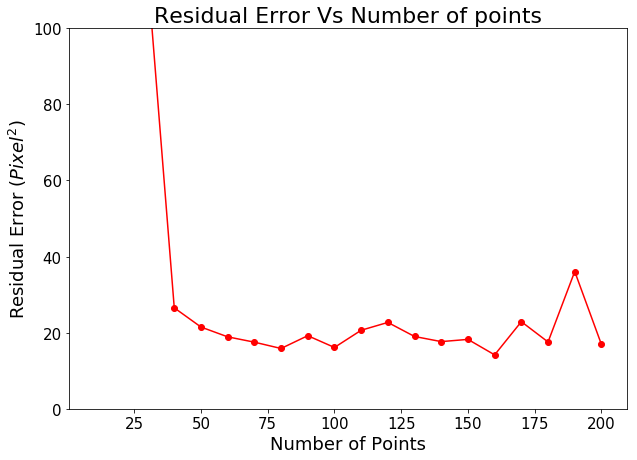

In [28]:
x = []
y = []

for key in data.keys():
    x.append(key)
    y.append(data[key])
    
plt.figure(figsize = (10, 7))
plt.plot(x, y, marker = 'o', color = 'r')
plt.title('Residual Error Vs Number of points', fontsize = 22)
plt.ylabel('Residual Error ($Pixel^2$)', fontsize=18)
plt.xlabel('Number of Points', fontsize=18)
plt.rc('xtick', labelsize=15)  
plt.rc('ytick', labelsize=15) 
plt.ylim([0, 100])
plt.savefig("foo.pdf", bbox_inches='tight')
plt.show()

In [19]:
res_LMEDS

defaultdict(dict,
            {'end': {10: 42762.33099327975,
              20: 65.78430596482465,
              30: 120.41679310309867,
              40: 59.996406556636295,
              50: 18.677388004095068,
              60: 109.51719520766684,
              70: 139.65235824232005,
              80: 68.90990758604055,
              90: 181.17689738441982,
              100: 15.823175150548124,
              110: 75.47382354230214,
              120: 186.91023007528227,
              130: 409.24039958934964,
              140: 21.638462089214016,
              150: 75.92698996975994,
              160: 13.903104113261756,
              170: 56.59164699068973,
              180: 43.22056438479947,
              190: 18.443412967905275,
              200: 69.52713405628936},
             'mix': {10: 33416.350848130794,
              20: 122.16528724242458,
              30: 106.61566663509825,
              40: 25.212484161491535,
              50: 20.74051459492106,
              6

In [3]:
from pointsMark import labelPoints

In [4]:
ptsL_end = np.load('./data_F/ptsL800_end.npy').item()
ptsR_end = np.load('./data_F/ptsR800_end.npy').item()

ptsL_out = np.load('./data_F/ptsL800_out.npy').item()
ptsR_out = np.load('./data_F/ptsR800_out.npy').item()

In [5]:
imgl = cv2.imread('../../data/CTR_Robot/Camera2/cam2_84.png')
imgr = cv2.imread('../../data/CTR_Robot/Camera1/cam1_84.png')

In [8]:
pt_end_l = tuple(np.array(ptsL_end[84]).astype('int'))
pt_end_r = tuple(np.array(ptsR_end[84]).astype('int'))

pt_mid_l = (708, 471)
pt_mid_r = (558, 504)

pt_out_l = ptsL_out[84]
pt_out_r = ptsR_out[84]

In [93]:
img = np.hstack((imgl, imgr))

cv2.line(img, (pt_end_l[0], pt_end_l[1]), (pt_end_r[0] + 1280, pt_end_r[1]), (255,255,255) , 2)
cv2.line(img, (pt_mid_l[0], pt_mid_l[1]), (pt_mid_r[0] + 1280, pt_mid_r[1]), (255,255,255) , 2)
cv2.line(img, (pt_out_l[0], pt_out_l[1]), (pt_out_r[0] + 1280, pt_out_r[1]), (255,255,255), 2)

cv2.circle(img, pt_end_l , 2, (0, 0, 255), 8)
cv2.circle(img, pt_mid_l , 2, (0, 255, 0), 8)
cv2.circle(img, pt_out_l , 2, (168, 50, 168), 8)

cv2.circle(img, (pt_end_r[0] + 1280, pt_end_r[1]) , 2, (0, 0, 255), 8)
cv2.circle(img, (pt_mid_r[0] + 1280, pt_mid_r[1]) , 2, (0, 255, 0), 8)
cv2.circle(img, (pt_out_r[0] + 1280, pt_out_r[1]) , 2, (168, 50, 168), 8)

cv2.imwrite('correspondingPts.jpg', img)

True

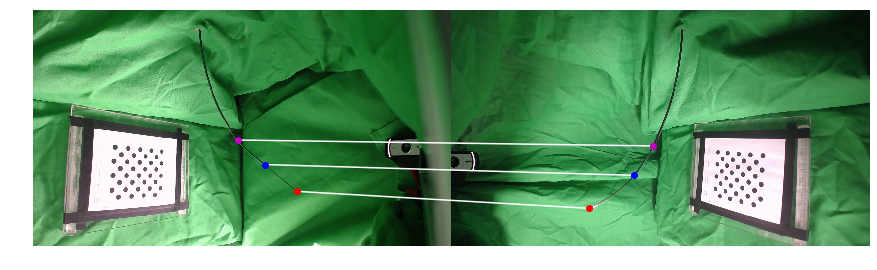

In [27]:
img = np.hstack((imgl, imgr))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize = (15, 10))
plt.plot([pt_end_l[0], pt_end_r[0] + 1280], [pt_end_l[1], pt_end_r[1]], c = 'w')
plt.plot([pt_mid_l[0], pt_mid_r[0] + 1280], [pt_mid_l[1], pt_mid_r[1]], c = 'w')
plt.plot([pt_out_l[0], pt_out_r[0] + 1280], [pt_out_l[1], pt_out_r[1]], c = 'w')

plt.plot(pt_end_l[0], pt_end_l[1], marker = 'o', c = 'r')
plt.plot(pt_mid_l[0], pt_mid_l[1], marker = 'o', c = 'b')
plt.plot(pt_out_l[0], pt_out_l[1], marker = 'o', c = 'm')

plt.plot(pt_end_r[0] + 1280, pt_end_r[1], marker = 'o', c = 'r')
plt.plot(pt_mid_r[0] + 1280, pt_mid_r[1], marker = 'o', c = 'b')
plt.plot(pt_out_r[0] + 1280, pt_out_r[1], marker = 'o', c = 'm')

plt.imshow(img)
plt.axis('off')
plt.savefig('correspondingPts.pdf', bbox_inches = 'tight')
plt.show()